# Computing venusquake detection probabilities from a balloon platform
The code computes the probability of observing a signal with SNR > threshold at a given location or along a balloon trajectory for a variety of seismicity scenarios.

## Building detection maps

In [1]:
%matplotlib widget
import proba_modules as pm
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
reload(pm)

<module 'proba_modules' from 'c:\\Users\\quentin\\Documents\\2024_Venus_Detectability\\proba_modules.py'>

### Rayleigh wave infrasound

In [2]:
from scipy import interpolate
file_atmos = './data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic')
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')
f_c = interpolate.interp1d(profile.altitude/1e3, profile.c, kind='quadratic')

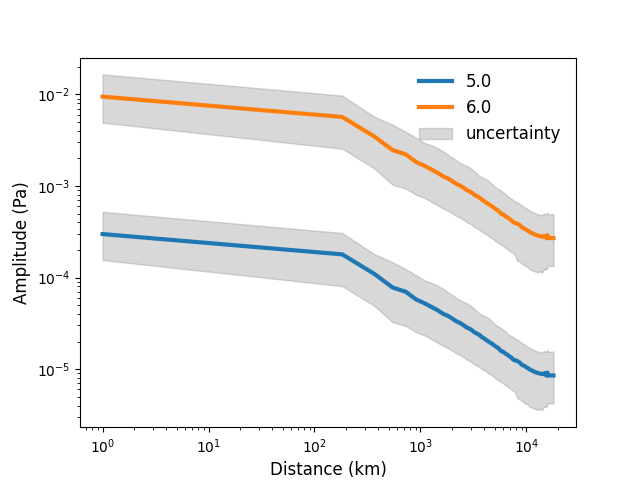

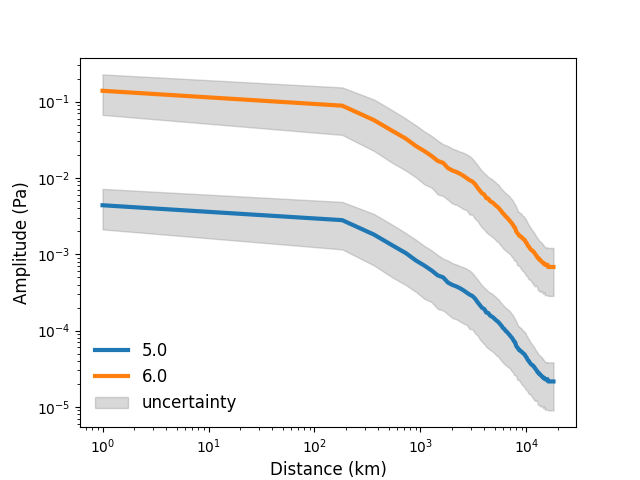

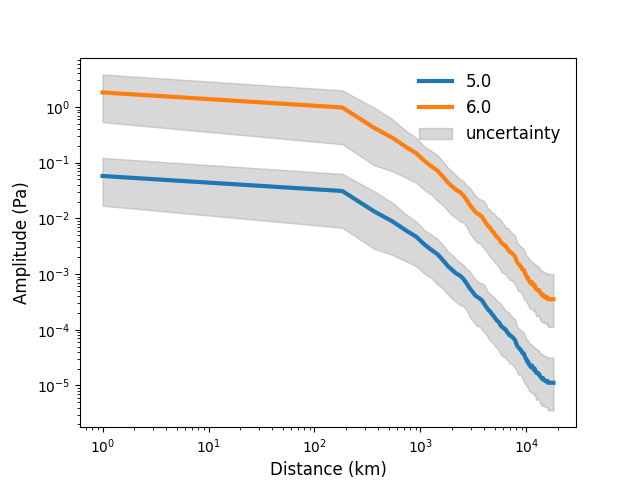

In [25]:
reload(pm)
file_curve = './data/GF_data/GF_Dirac_1Hz_all_wfreq.csv'
freq = [0.01, 0.1, 1.]
alt_balloon = 45.
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(alt_balloon), use_savgol_filter=True, plot=False, scalar_moment=10e6, unknown='pressure', return_dataframe=False)

### Venusquakes: Iris' model

In [18]:
file_slopes = './data/Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

#file_ratio = './data/surface_ratios/surface_ratios_active_fixed.csv'
#file_ratio = './data/surface_ratios_fixed.csv'
file_ratio = './data/surface_ratios/surface_ratios_airglow_active.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

FileNotFoundError: [Errno 2] No such file or directory: './data/surface_ratios/surface_ratios_airglow_active.csv'

In [28]:
reload(pm)

dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'active_low_min', # Iris' seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 1e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-89, 90, dlat),
    all_lons = np.arange(0, 359, dlat*2),
    #all_lats = np.arange(-90., 90.+dlat, dlat),
    #all_lons = np.arange(-180, 180+dlat*2, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
)

period = 1.
proba_model = pm.proba_model(pd_slopes, surface_ratios, TL_new[period], TL_new_qmin[period], TL_new_qmax[period])
proba_model.compute_proba_map(**opt_model)

  0%|          | 0/36 [00:00<?, ?it/s]


ValueError: attempt to get argmin of an empty sequence

### Venusquakes: Airglow

In [33]:
regions = ['corona', 'intraplate', 'ridge', 'rift']
surface_ratios = pd.DataFrame()
for region in regions:
    file_ratio = f'./data/surface_ratios/surface_ratios_airglow_{region}_active.csv'
    surface_ratios_loc = pm.get_surface_ratios(file_ratio)
    surface_ratios_loc['region'] = region
    surface_ratios = pd.concat([surface_ratios, surface_ratios_loc])
surface_ratios.reset_index(drop=True, inplace=True)
surface_ratios

,iloc,lon,lat,iradius,radius,ratio,ratio_map,region
0,1205,0,-89,0,10000.0,0.000000,0.000000,corona
1,1205,0,-89,1,510000.0,0.010234,0.385843,corona
2,1205,0,-89,2,1010000.0,0.011229,0.423357,corona
3,1205,0,-89,3,1510000.0,0.012181,0.459228,corona
4,1205,0,-89,4,2010000.0,0.012593,0.474776,corona
...,...,...,...,...,...,...,...,...
196987,1295,350,86,33,16510000.0,0.004136,0.052333,rift
196988,1295,350,86,34,17010000.0,0.004165,0.052701,rift
196989,1295,350,86,35,17510000.0,0.004165,0.052701,rift
196990,1295,350,86,36,18010000.0,0.004182,0.052915,rift


In [54]:
file_ratio = f'./data/surface_ratios/surface_ratios_active_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)
surface_ratios

,iloc,lon,lat,iradius,radius,ratio,ratio_map,region
0,0,0,-89,0,10000.0,0.000000,0.000000,corona
1,0,0,-89,1,510000.0,0.000000,0.000000,corona
2,0,0,-89,2,1010000.0,0.000000,0.000000,corona
3,0,0,-89,3,1510000.0,0.000000,0.000000,corona
4,0,0,-89,4,2010000.0,0.000000,0.000000,corona
...,...,...,...,...,...,...,...,...
196987,1295,350,86,33,16510000.0,0.794603,0.910033,intraplate
196988,1295,350,86,34,17010000.0,0.814657,0.933001,intraplate
196989,1295,350,86,35,17510000.0,0.833449,0.954523,intraplate
196990,1295,350,86,36,18010000.0,0.849437,0.972833,intraplate


In [51]:
reload(pm)

dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'active_low_min', # Iris' seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 1e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.array([0.]),
    all_lons = np.arange(0, 359, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
)

period = 0.01
proba_model = pm.proba_model(pd_slopes, surface_ratios, TL_new[period], TL_new_qmin[period], TL_new_qmax[period])
proba_model.compute_proba_map(**opt_model)

100%|██████████| 36/36 [00:10<00:00,  3.35it/s]


### Venusquakes: Wrinkle Ridges

In [ ]:
file_slopes = './data/wrinkle_ridges/distribution_venus_per_mw_wrinkles.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_ratio = './data/surface_ratios/surface_ratios_wrinkles_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

"""
file_ratio = './data/surface_ratios_wrinkles.csv'
surface_ratios = pd.read_csv(file_ratio, header=[0])
surface_ratios['region'] = 'wrinkle_ridges'

iloc = -1
for _, group in surface_ratios.groupby(['lon', 'lat']):
    iloc += 1
    surface_ratios.loc[surface_ratios.index.isin(group.index), 'iloc'] = iloc
surface_ratios.to_csv('./data/surface_ratios_wrinkles_fixed.csv', header=True, index=False)
"""

In [ ]:
setting = pd_slopes.type_setting.iloc[0]
cat_quake = 'wrinkle_ridges'
popt = pd_slopes.loc[(pd_slopes.type_setting==setting), cat_quake].values
poly1d = np.poly1d(popt)
func = lambda mw: 10**poly1d(mw)

Mws = np.linspace(3.5, 8.7, 1000)
ylim = [1e-2, 10e6]
xlim = [Mws.min(), Mws.max()]
plt.figure(facecolor='none')
plt.plot(Mws, func(Mws), linewidth=3., color='red', linestyle='--')
plt.yscale('log')
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_facecolor('none')

In [ ]:
reload(pm)

dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'wrinkle_ridges', # Leah's seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 1e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-89, 90, dlat),
    all_lons = np.arange(0, 359, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
)

proba_model_wrinkles = pm.proba_model_wrinkles(pd_slopes, surface_ratios, TL_new, TL_new_qmin, TL_new_qmax)
proba_model_wrinkles.compute_proba_map(**opt_model)

### Volcanoes: volcanic seismicity + epicentral infrasound

In [ ]:
import proba_modules as pm
reload(pm)

file_volcano = './data/Venus_data/05_large_greaterthan100.csv'
volcanoes = pm.get_volcano_locations(file_volcano)

file_slopes = './data/Venus_data/distribution_venus_per_VEI.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_curve = './data/GF_data/GF_reverse_fault_1Hz.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves_with_EI(file_curve, dist_min=100., alt_balloon=50.)

file_ratio = './data/GF_data/surface_ratios_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

dlat = 5.
r_venus = 6052
lat_volcanoes = volcanoes['Lat_Center'].values
lon_volcanoes = volcanoes['Lon_Center'].values
opt_model = dict(
    scenario = 'active_high', # Iris' seismicity scenario
    dists = None, # dists not provided for Volcanoes beca
    M0s = np.linspace(0., 6., 30), # VEIs - Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 5e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-90., 90.+dlat, dlat),
    all_lons = np.arange(-180, 180+dlat*2., dlat*2.),
    homogeneous_ratios = False,
    m_min = 0.,
    r_venus = r_venus,
    return_rate=True, 
    rates_provided=None, 
)

proba_model_volcanoes = pm.proba_model_volcano(lat_volcanoes, lon_volcanoes, pd_slopes, surface_ratios, TL_new, TL_new_qmin, TL_new_qmax)
proba_model_volcanoes.compute_proba_map(**opt_model)

## Trajectories

In [4]:
import VCD_trajectory_modules as VCD
from importlib import reload
reload(VCD)

<module 'VCD_trajectory_modules' from 'c:\\Users\\quentin\\Documents\\2024_Venus_Detectability\\VCD_trajectory_modules.py'>

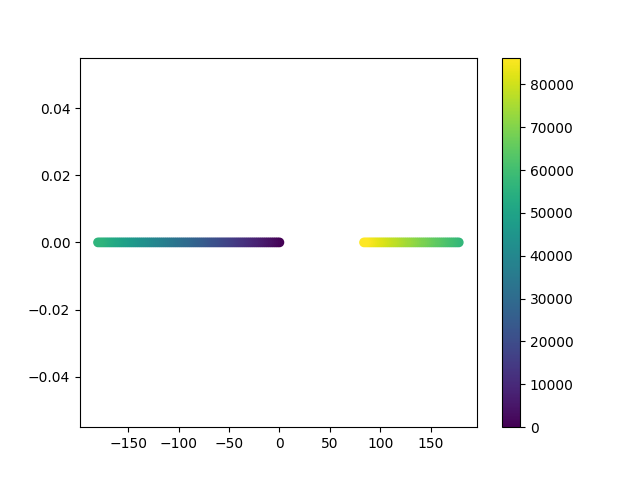

In [17]:
reload(VCD)
start_lon = 0.
dlon = 2.
trajectory = VCD.compute_trajectory_airglow(start_lon, dlon, velocity_imager=-0.32, time_max=3600*24)

#plt.figure()
#sc = plt.scatter(trajectory.lon, trajectory.lat, c=trajectory.time)
#plt.colorbar(sc)

In [19]:
reload(VCD)

file_atmos = './data/VCD_atmos_globe.dat'
altitude = 40e3
winds = VCD.get_winds(file_atmos, altitude)

c:\Users\quentin\Documents\2024_Venus_Detectability\VCD_trajectory_modules.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['gid'] = winds.groupby(['lat', 'lon'])['val'].transform('idxmin')
c:\Users\quentin\Documents\2024_Venus_Detectability\VCD_trajectory_modules.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['wind_strength'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.sqrt(sum(x**2)))
c:\Users\quentin\Documents\2024_Venus_Detectability\VCD_trajectory_modules.py:21: 

In [34]:
reload(VCD)

start_location = [-45.,0.] # lat, lon
opt_trajectory = dict(
    time_max=3600*24*30*2,
    save_trajectory=False,
    folder = './data/',
)
trajectory = VCD.compute_trajectory(winds, start_location, **opt_trajectory)

#file = './data/trajectory_balloon_lat0.00_lon0.00_15days.csv'
#file = './data/trajectory_balloon_lat50.00_lon50.00_15days.csv'
#trajectory = pd.read_csv(file, header=[0])

## Visualization

### Venusquakes - Map

In [47]:
reload(pm)

PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}Venus_data/tectonic_settings_Venus")
VENUS = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp"),
}

opt_visualization = dict(
    VENUS = VENUS,
    c_cbar = 'black', 
    l_snr_to_plot = [1.,2.5], 
    n_colors = 10,
    plot_all_regions = True,
    use_active_corona = True
)

## active high
"""
opt_visualization.update(dict(
    low_cmap = np.arange(0.05, 0.35, 0.05), # 1 day RW low activity
    high_cmap = np.arange(0.6, 1.2, 0.1),))
"""
## active low
"""
opt_visualization.update(dict(
    low_cmap = np.arange(0.4, 0.6, 0.05), # 1 day RW low activity
    high_cmap = np.arange(0.6, 1.6, 0.1),))
"""

pm.plot_map(proba_model, **opt_visualization)

NameError: name 'os' is not defined

### Venusquakes - trajectories

In [46]:
reload(pm)

snrs = proba_model.SNR_thresholds
lats, lons = proba_model.all_lats, proba_model.all_lons
probas = proba_model.proba_all.copy() # SNR x lats x lons
new_trajectories = pm.compute_proba_one_trajectory(trajectory, snrs, lats, lons, probas, norm_factor_time=3600.) ## Venusquakes
#new_trajectories = pm.compute_proba_one_trajectory(trajectory, proba_model_volcanoes, norm_factor_time=3600.) ## Volcanoes

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.15it/s]


In [48]:
new_trajectories

,time,lat,lon,dt,bin_dt,id_map,lat_map,lon_map,proba,snr
0,0.0,0.0,0.0,0.000000,0,0,0.0,0.0,0.000099,1.0
1,625.0,0.0,-2.0,0.173611,1,0,0.0,0.0,0.000198,1.0
2,1250.0,0.0,-4.0,0.347222,1,0,0.0,0.0,0.000198,1.0
3,1875.0,0.0,-6.0,0.520833,1,35,0.0,350.0,0.000198,1.0
4,2500.0,0.0,-8.0,0.694444,1,35,0.0,350.0,0.000198,1.0
...,...,...,...,...,...,...,...,...,...,...
412,83750.0,0.0,92.0,23.263889,24,9,0.0,90.0,0.000849,5.0
413,84375.0,0.0,90.0,23.437500,24,9,0.0,90.0,0.000849,5.0
414,85000.0,0.0,88.0,23.611111,24,9,0.0,90.0,0.000849,5.0
415,85625.0,0.0,86.0,23.784722,24,9,0.0,90.0,0.000849,5.0


In [ ]:
reload(VCD)
reload(pm)

lats = np.linspace(-65., 65., 25)
lons = np.linspace(-180., 179., 30)
LATS, LONS = np.meshgrid(lats, lons)
LATS, LONS = LATS.ravel(), LONS.ravel()
mission_durations = [30., 60., 90., 120., 240., 360.]
max_number_months = np.max(mission_durations)/30.

snrs = proba_model.SNR_thresholds
lats, lons = proba_model.all_lats, proba_model.all_lons
probas = proba_model.proba_all.copy() # SNR x lats x lons
pd_final_probas = pm.compute_multiple_trajectories(snrs, lats, lons, probas, winds, lats, lons, mission_durations, max_number_months, (0, LATS, LONS))

In [9]:
lats = np.linspace(-65., 65., 25)
lons = np.linspace(-180., 179., 30)
mission_durations = [30., 60., 90., 120.]
pd_final_probas = pd.read_csv('./data/final_probas_active_low_min_n0.01_alt40.csv')
pd_final_probas

,snr,proba,lat,lon,duration
0,1.0,0.181319,-65.0,-180.0,30.0
1,2.0,0.117020,-65.0,-180.0,30.0
2,5.0,0.065911,-65.0,-180.0,30.0
3,1.0,0.320046,-65.0,-180.0,60.0
4,2.0,0.213334,-65.0,-180.0,60.0
...,...,...,...,...,...
8995,2.0,0.301157,65.0,179.0,90.0
8996,5.0,0.178236,65.0,179.0,90.0
8997,1.0,0.516245,65.0,179.0,120.0
8998,2.0,0.363446,65.0,179.0,120.0


C:\Users\quentin\AppData\Local\Temp\ipykernel_14092\2048563606.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Reds", lut=len(cmap_bounds))
C:\Users\quentin\AppData\Local\Temp\ipykernel_14092\2048563606.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = m.pcolormesh(x, y, field.T, cmap=cmap, norm=norm)
C:\Users\quentin\AppData\Local\Temp\ipykernel_14092\2048563606.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply 

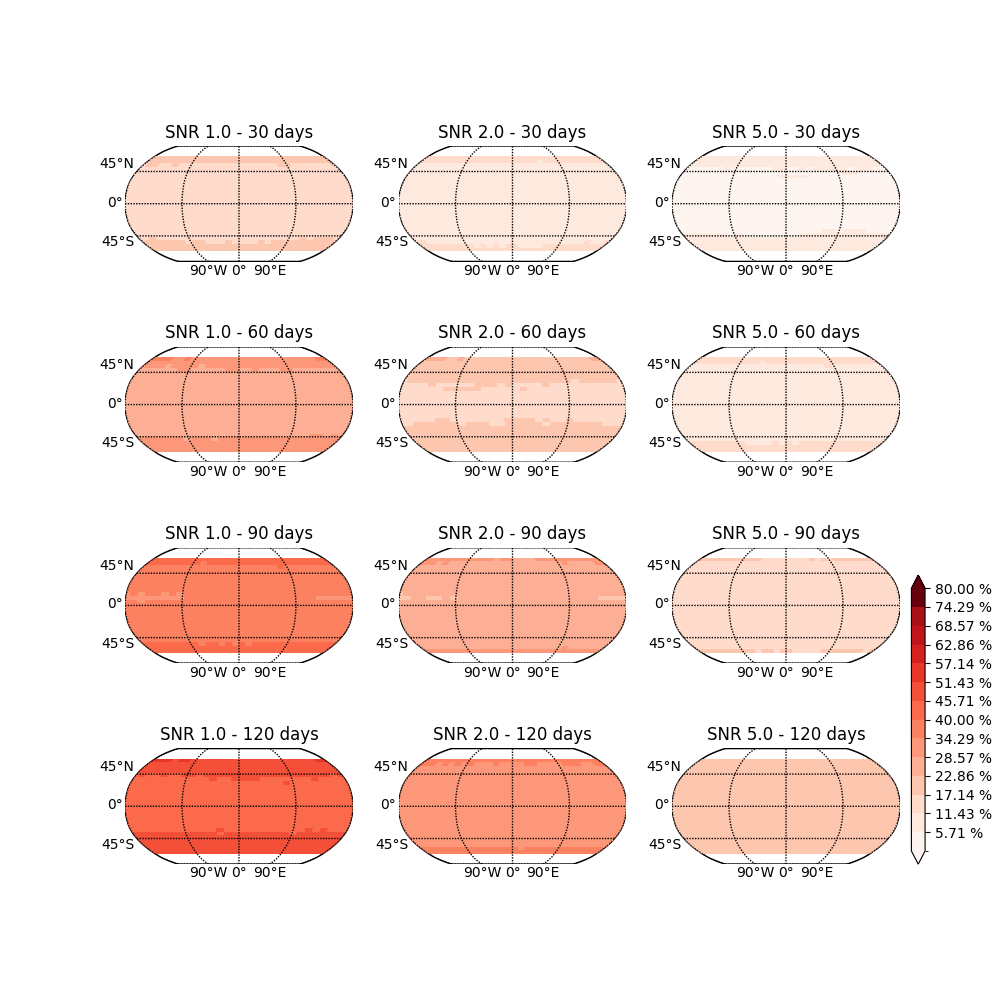

In [10]:
import matplotlib.cm as cm
import matplotlib.colors as mcol
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap

LONS, LATS = np.meshgrid(lons, lats)

cmap_bounds = np.linspace(0., 0.8, 15)
cmap = cm.get_cmap("Reds", lut=len(cmap_bounds))
norm = mcol.BoundaryNorm(cmap_bounds, cmap.N)
    
fig = plt.figure(figsize=(10,10))
grid = fig.add_gridspec(len(mission_durations), 3)
iduration = -1
for duration, one_duration in pd_final_probas.groupby('duration'):
    iduration += 1
    isnr = -1
    for snr, one_snr in one_duration.groupby('snr'):
        isnr +=1
        field = one_snr.proba.values.reshape(lons.size, lats.size)
        
        
        ax = fig.add_subplot(grid[iduration, isnr])
        m = Basemap(projection='robin', lon_0=0, ax=ax)
        m.drawmeridians(np.linspace(-180., 180., 5), labels=[0, 0, 0, 1], fontsize=10,)
        m.drawparallels(np.linspace(-90., 90., 5), labels=[1, 0, 0, 0], fontsize=10,)
        x, y = m(LONS.ravel(), LATS.ravel())
        x, y = x.reshape(LONS.shape), y.reshape(LONS.shape)
        sc = m.pcolormesh(x, y, field.T, cmap=cmap, norm=norm)
        #plt.colorbar(sc)
        plt.title(f'SNR {snr} - {duration:.0f} days')

fmt = lambda x, pos: '{:.2f} %'.format(x*1e2) # 
axins = inset_axes(ax, width="6%", height="250%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
cbar = fig.colorbar(sc, format=FuncFormatter(fmt), cax=axins, orientation='vertical', extend='both', ticks=cmap_bounds[1:],)

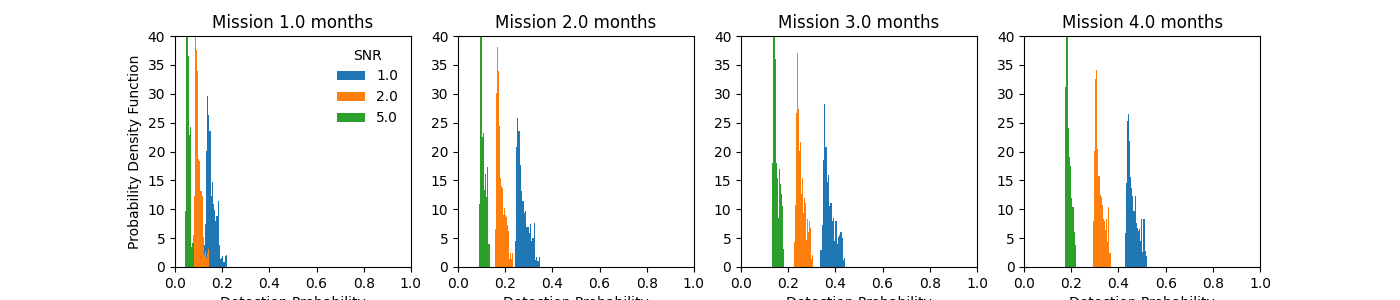

In [12]:
fig = plt.figure(figsize=(14,3))
grid = fig.add_gridspec(1, len(mission_durations))
iduration = -1
for duration, one_duration in pd_final_probas.groupby('duration'):
    iduration += 1
    ax = fig.add_subplot(grid[0, iduration])
    #print(duration)
    ax.set_title(f'Mission {duration/30.:.1f} months')
    for snr, one_snr in one_duration.groupby('snr'):
        #values, bins = np.histogram(one_snr.proba, bins=20)
        #bin_centers = 0.5 * (bins[:-1] + bins[1:])
        #ax.bar(bin_centers, values/, width=(bins[1] - bins[0]), label=snr)
        ax.hist(one_snr.proba, bins=20, label=snr, density=True)
    ax.set_xlabel('Detection Probability')
    if iduration == 0:
        ax.legend(title='SNR', frameon=False)
        ax.set_ylabel('Probability Density Function')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 40.])

c:\Users\quentin\Documents\2024_Venus_Detectability\proba_modules.py:1391: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  #ax_vs_time.legend(frameon=False, title='SNR')
c:\Users\quentin\Documents\2024_Venus_Detectability\proba_modules.py:1409: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax_vs_time.tick_params(axis='both', colors=c_cbar, labelsize=fontsize)


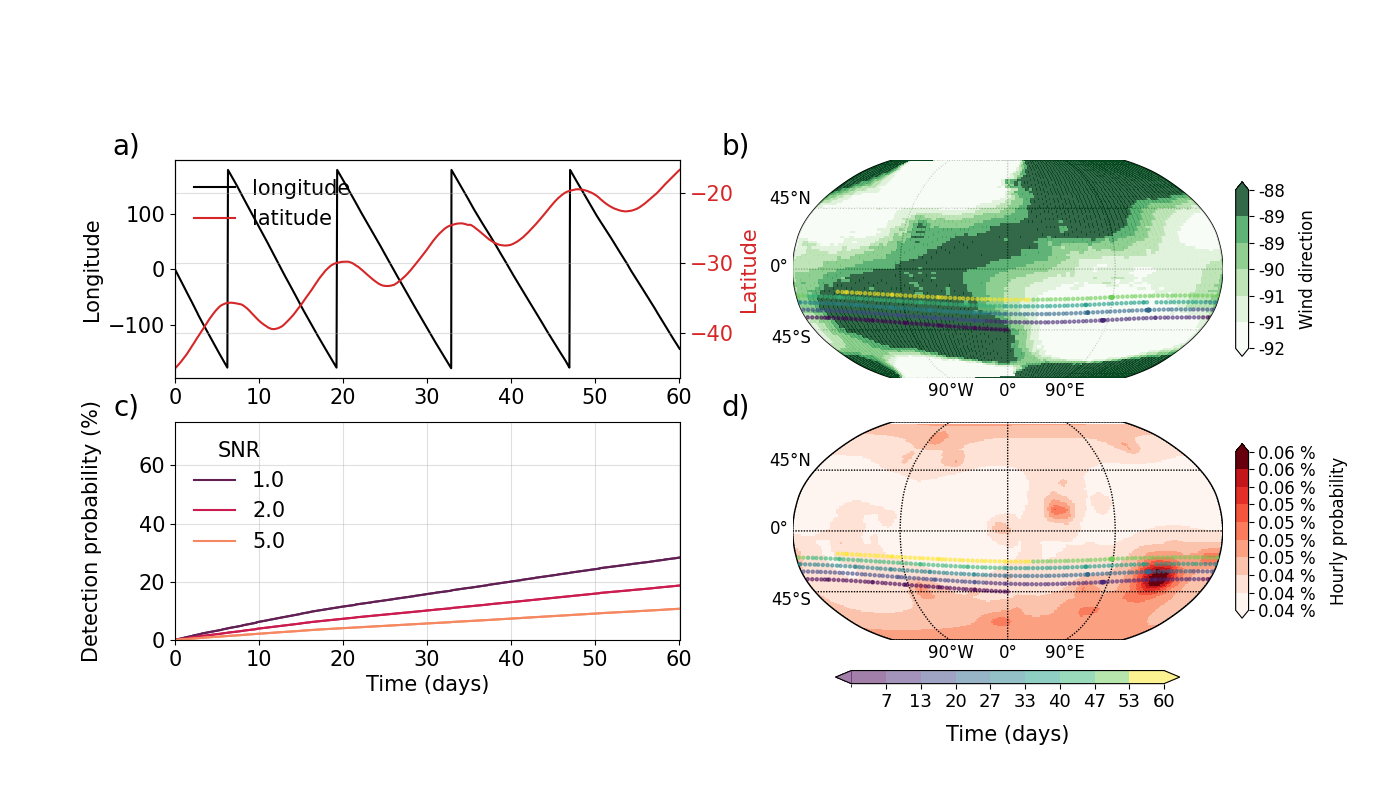

: 

In [50]:
reload(pm)

opt_visualization = dict(
    VENUS=None,#pm.get_regions('../../../Venus_data/')
    snr=2., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 75.],
    plot_time=True,
    plot_volcanoes=False
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model, winds, **opt_visualization)

### Wrinkle Ridges - map

In [721]:
PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}wrinkle_ridges")
VENUS = dict(wrinkles=gpd.read_file(f"{PATH_VENUS}/wrinkle_ridges.shp"))

In [ ]:
reload(pm)

opt_visualization = dict(
    VENUS = VENUS,
    c_cbar = 'black', 
    l_snr_to_plot = [1.,2.5], 
    n_colors = 10,
    plot_all_regions = True,
    use_active_corona = True
)

## active low
opt_visualization.update(dict(
    low_cmap = np.arange(0.1, 0.15, 0.025), # 1 day RW wrinkles
    high_cmap = np.arange(0.15, 0.33, 0.025),))

pm.plot_map(proba_model_wrinkles, **opt_visualization)

### Wrinkle Ridges - trajectories

In [ ]:
reload(pm)

lats = np.linspace(-65., 65., 25)
lons = np.linspace(-180., 179., 30)
mission_durations = [15., 30., 45., 60.]
pd_final_probas_wrinkles = pm.compute_multiple_trajectories(proba_model_wrinkles, winds, lats, lons, mission_durations)

In [ ]:
reload(pm)

pm.plot_maps_all_trajectories(pd_final_probas_wrinkles, lons, lats, mission_durations, cmap_bounds=np.linspace(0., 0.1, 15))

In [ ]:
reload(pm)

pm.plot_proba_all_trajectories(pd_final_probas_wrinkles, mission_durations, xlim=[0, 0.1], ylim=[0, 150.])

In [ ]:
reload(pm)

new_trajectories = pm.compute_proba_one_trajectory(trajectory, proba_model_wrinkles, norm_factor_time=3600.) ## Wrinkles

In [ ]:
reload(pm)

opt_visualization = dict(
    VENUS=None,
    snr=2., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 75.],
    plot_time=True,
    plot_volcanoes=False
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model_wrinkles, winds, **opt_visualization)

### Volcanoes - trajectories

In [ ]:
reload(pm)

opt_visualization = dict(
    VENUS=None,#pm.get_regions('../../../Venus_data/')
    snr=1., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 20.],
    plot_time=True,
    plot_volcanoes=True
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model_volcanoes, **opt_visualization)

## Visualize internal PDFs (i.e., step by step process) 

In [ ]:
mag, dist = 5., 1000.

imag = np.argmin(abs(M0s-mag))
iloc = 9
isnr = 5

durations = np.linspace(1./365., 100./365., 50)
DUR, THRESH = np.meshgrid(durations, SNR_thresholds)
proba_durations = np.zeros((durations.size,)+proba.shape)
for iduration, duration in enumerate(durations):
    proba_durations[iduration,:,:] = compute_Poisson(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, duration, pd_slopes, scenario, rates=rates)

fig = plt.figure(figsize=(16,3))
grid = fig.add_gridspec(1, 6)

ax = fig.add_subplot(grid[0, 0])
for dist in [500., 1000.]:
    idist = np.argmin(abs(dists-dist))
    #sigma = sigma_TL/noise_level
    #mu = TL(dists[idist], M0s[imag])/noise_level
    mu = compute_TL(dists[idist], M0s[imag])/noise_level
    sigma = mu*(10**sigma_TL - 1.)
    ax.plot(SNR_thresholds, (1./(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((SNR_thresholds-mu)/sigma)**2))
ax.set_title(M0s[imag])

ax = fig.add_subplot(grid[0, 1])
#ax.plot(detection_thresholds, cum_pdf[imag, idist, :, iloc])
test_cum = 0.5*(1+special.erf( (SNR_thresholds-mu)/(sigma*np.sqrt(2.)) ))
ax.plot(SNR_thresholds, 1-test_cum)
ax.set_ylim([0.,1])

ax = fig.add_subplot(grid[0, 2])
for rate in rates:
    ax.plot(SNR_thresholds, rate[:,iloc])
ax.set_yscale('log')

ax = fig.add_subplot(grid[0, 3])
ax.pcolormesh(THRESH, DUR*12, proba_durations[:,:,iloc].T, vmax=1., vmin=0.)
ax.set_title(f'lat/lon: {lats[iloc]:.2f}/{lons[iloc]:.2f}')
#ax.plot(proba_durations[20,:,iloc])
#ax.set_ylim([-0.,1.1])

ax = fig.add_subplot(grid[0, 4])
for region in RATIOs:
    ax.plot(dists, RATIOs[region].reshape(shape_init)[0,:,0,iloc])
    
ax = fig.add_subplot(grid[0, 5])
sc = ax.pcolormesh(all_lons, all_lats, proba_all_other[isnr,:])
#sc = ax.plot(lats_orig, proba_all_other[isnr,:,ilon])
ax.set_title(f'SNR: {SNR_thresholds[isnr]:.2f}')
plt.colorbar(sc)
#ax.set_ylim([0.,1.1])

## Plot schematic

In [ ]:
import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
    

compute_TL = lambda dist, alpha, M0: M0*10*dist**(-alpha)
compute_SNR = lambda dist, alpha, M0, noise_level: compute_TL(dist, alpha, M0)/noise_level
compute_distrib = lambda SNR, sigma_TL, dist, alpha, M0, noise_level: np.exp(-((SNRs-compute_SNR(dist, alpha, M0, noise_level))/sigma_TL)**2) 
SNRs=np.linspace(0., 5, 100)
dists=[100, 200, 500]
sigma_TL=0.3
noise_level=0.1
alpha=0.7
SNR_t=2.5
l_dists = np.linspace(10., 1100., 100)
plt.rcParams['text.usetex'] = False
def plot_TL_vs_distance(ax, M0=1):
    for idist, dist in enumerate(dists):
        one_distrib = compute_distrib(SNRs, sigma_TL, dist, alpha, M0, noise_level)
        factor = 500.
        label = {}
        if idist == 0:
            label['label'] = 'f_{TL}($M_0$) = TL($M_0$)/$\sigma_n$'
        plt.plot(factor*one_distrib+dist, SNRs, zorder=10, color='tab:blue', **label)
        #plt.plot(factor*one_distrib, SNRs)
        
        if idist < 2:
            i_last_SNR = np.argmin(abs(SNRs-SNR_t))
            shape_dist = np.r_[one_distrib[i_last_SNR:], np.array([0., one_distrib[i_last_SNR]])]
            shape_SNR = np.r_[SNRs[i_last_SNR:], np.array([SNR_t, SNR_t])]
            ax.fill(factor*shape_dist+dist, shape_SNR, alpha=0.5, color='tab:blue')
        
    
    ax.plot(l_dists, compute_SNR(l_dists, alpha, M0, noise_level), zorder=1, alpha=0.1, linewidth=3., color='black')
    ax.axhline(SNR_t, color='tab:blue', zorder=2, alpha=0.5, linestyle=':')
    ax.set_ylim([SNRs.min(), SNRs.max()])
    ax.set_xlim([l_dists.min(), l_dists.max()])
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('SNR')
    ax.legend(frameon=False)

fig = plt.figure(figsize=(14,4))
grid = fig.add_gridspec(1, 3)

ax = fig.add_subplot(grid[0, 0])
plot_TL_vs_distance(ax)
eq2 = ("$\int_{SNR=d}^\infty f_{TL}(SNR=d,M_0,r)dSNR$")
ax.text(0.9, -0.35, eq2, color="C0", fontsize=16, transform=ax.transAxes, ha='center')

ax = fig.add_subplot(grid[0, 1])
test_cum = 0.5*(1+special.erf( (SNR_t-compute_SNR(l_dists, alpha, 2, noise_level))/(sigma_TL*np.sqrt(2.)) ))
ax.plot(l_dists, 1-test_cum, color='tab:orange')
ax.fill_between(l_dists, 1-test_cum, alpha=0.5, color='tab:orange', label='$M_1$')
test_cum = 0.5*(1+special.erf( (SNR_t-compute_SNR(l_dists, alpha, 1., noise_level))/(sigma_TL*np.sqrt(2.)) ))
ax.plot(l_dists, 1-test_cum, color='tab:blue')
ax.fill_between(l_dists, 1-test_cum, alpha=0.5, color='tab:blue', label='$M_0$')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('$\mathbb{P}(SNR>d|M_0,r)$')
ax.legend(frameon=False)
eq2 = ("$\int_{M_0=M_{min}}^{M_{max}}\int_{r=0}^{r_{venus}}\mathbb{P}(SNR>d|M_0,r)f_{M}^{tec}(M_0)f^{tec}_{R}(r)drdM_0$")
ax.text(1.4, -0.35, eq2, color="C0", fontsize=16, transform=ax.transAxes, ha='center')
arrow = patches.FancyArrowPatch((-0.3, -0.15), (0.1, -0.15), connectionstyle="arc3,rad=.2", transform=ax.transAxes, clip_on=False, **kw)
ax.add_patch(arrow)

if True:
    ax = fig.add_subplot(grid[0, 2])
    iloc = 10
    iregion = 0
    ax.plot(SNR_thresholds, rate[iregion][:,iloc]/Nquake_over_mag(m_min, iregion), label='Region 0', color='tab:green')
    iregion = 1
    ax.plot(SNR_thresholds, rate[iregion][:,iloc]/Nquake_over_mag(m_min, iregion), label='Region 1', color='tab:pink')

    ax.set_ylabel('$\mathbb{P}(SNR>d|tec)$')
    ax.set_xlabel('d (SNR)')

    arrow = patches.FancyArrowPatch((-0.3, -0.15), (0.1, -0.15), connectionstyle="arc3,rad=.2", transform=ax.transAxes, clip_on=False, **kw)
    ax.add_patch(arrow)
    
    ax.legend(frameon=False)

fig.subplots_adjust(bottom=0.3)
fig.savefig('./schematic_proba_model.pdf')